In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
sns.set()

from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
sim_metadata_fold = "../../../data/carla_sim/random_spawn/"
sim_responses_fold = "../../../data/experiments/carla_sim/random_spawn/"

samples = os.listdir(sim_metadata_fold)

In [5]:
samples

['example_0',
 'example_1',
 'example_10',
 'example_100',
 'example_101',
 'example_102',
 'example_103',
 'example_104',
 'example_105',
 'example_106',
 'example_107',
 'example_108',
 'example_109',
 'example_11',
 'example_110',
 'example_111',
 'example_112',
 'example_113',
 'example_114',
 'example_27',
 'example_28',
 'example_29',
 'example_3',
 'example_30',
 'example_31',
 'example_32',
 'example_33',
 'example_34',
 'example_35',
 'example_36',
 'example_37',
 'example_38',
 'example_39',
 'example_4',
 'example_40',
 'example_41',
 'example_42',
 'example_43',
 'example_45',
 'example_46',
 'example_47',
 'example_48',
 'example_49',
 'example_5',
 'example_50',
 'example_51',
 'example_52',
 'example_53',
 'example_54',
 'example_55',
 'example_56',
 'example_57',
 'example_58',
 'example_59',
 'example_6',
 'example_60',
 'example_61',
 'example_63',
 'example_64',
 'example_65',
 'example_66',
 'example_67',
 'example_68',
 'example_69',
 'example_7',
 'example_70',
 '

In [6]:
df_metadata = pd.DataFrame(columns=["sample_id", "coll_type", "coll_time", "t_end", "vel", "diameter", "dt"])

for sample in samples:
    smd = np.load(sim_metadata_fold + sample + "/sim_data.npz", allow_pickle=True)
    df_metadata = pd.concat(
        [
            df_metadata,
            pd.DataFrame(
                {
                    "sample_id": sample.split("_")[1],
                    "coll_type": [smd["coll_type"][()]],
                    "coll_time": [smd["collision_time"][()]],
                    "t_end": [smd["t_end"][()]],
                    "vel": [smd["vel"][()]],
                    "diameter": [smd["diameter_object"][()]],
                    "dt": [smd["dt"][()]],
                }
            ),
        ], ignore_index=True
    )

df_metadata['coll_type'].replace(to_replace=[None], value='none', inplace=True)

/tmp/ipykernel_128074/2465735888.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metadata = pd.concat(


In [7]:
df_metadata

,sample_id,coll_type,coll_time,t_end,vel,diameter,dt
0,0,cars,2429,2429,4.529172,2.612508,10.0
1,1,pedestrians,1659,1659,7.947197,0.889352,10.0
2,10,none,4000,4000,7.946603,NaN,10.0
3,100,pedestrians,1659,1659,7.947036,0.929854,10.0
4,101,cars,1399,1399,7.945492,2.727977,10.0
...,...,...,...,...,...,...,...
128,21,none,4009,4009,6.572920,NaN,10.0
129,22,cars,1499,1499,7.947430,2.826570,10.0
130,23,none,4009,4009,7.946305,NaN,10.0
131,24,none,4009,4009,6.994802,NaN,10.0


In [8]:
#models = ["EMD"]#["LGMD", "EMD"]
#models = ["LGMD"]
models = ["LGMD", "EMD"]
tiles = [3, 5, 7]

tile_id_range_y = {3: (1,1), 5: (1,2,3), 7: (2,3,4)}

df_responses = pd.DataFrame(
    columns=[
        "sample_id",
        "model",
        "n tiles",
        "tile_idx_y",
        "tile_idx_x",
        "coll_type",
        "coll_time",
        "vel",
        "diameter",
        "voltage",
        "time",
    ]
)

for model in models:
    print(model)
    for ntile in tiles:
        print(ntile)
        for sample in samples:
            try:
                sample_id = sample.split("_")[1]
                sample_metadata = df_metadata[df_metadata["sample_id"] == sample_id].iloc[0]
                smd = np.load(os.path.join(sim_responses_fold, model, str(ntile) + "_tiles", sample + ".npz"))
                for idx_x in range(ntile):
                    for idx_y in tile_id_range_y[ntile]:
                        df_responses = pd.concat([df_responses, pd.DataFrame({
                            "sample_id": sample_id,
                            "model": model,
                            "n tiles": ntile,
                            "tile_idx_x": idx_x,
                            "tile_idx_y": idx_y,
                            "coll_type": sample_metadata["coll_type"],
                            "coll_time": sample_metadata["coll_time"],
                            "vel": sample_metadata["vel"],
                            "diameter": sample_metadata["diameter"],
                            "voltage": smd["v_out"][idx_y, idx_x],
                            "time":  (((sample_metadata["dt"] * np.arange(smd["v_out"].shape[2]) - sample_metadata["coll_time"]))/100).astype(int) * 100,
                        })], ignore_index=True)

            except OSError as e:
                #print("could not find file")
                pass

LGMD
3


/tmp/ipykernel_128074/2669751733.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_responses = pd.concat([df_responses, pd.DataFrame({


5
7
EMD
3
5
7


In [43]:
df_responses['time'] = pd.to_numeric(df_responses['time'])
df_responses["n tiles"] = pd.to_numeric(df_responses["n tiles"])
df_responses["coll_time"] = pd.to_numeric(df_responses["coll_time"])
df_responses["voltage"] = pd.to_numeric(df_responses["voltage"]).astype(float)
df_responses['L/v'] = df_responses['diameter'] / df_responses['vel']

In [44]:
df_responses["voltage"]

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
             ...   
2023618    0.000350
2023619    0.000285
2023620    0.000224
2023621    0.000171
2023622    0.000136
Name: voltage, Length: 2023623, dtype: float64

In [23]:
df_responses.to_csv(os.path.join(sim_responses_fold, "responses.csv"))

In [1]:
df_responses = pd.read_csv(os.path.join(sim_responses_fold, "responses.csv"))

NameError: name 'pd' is not defined

In [24]:
df_responses

,sample_id,model,n tiles,tile_idx_y,tile_idx_x,coll_type,coll_time,vel,diameter,voltage,time,L/v
0,0,LGMD,3,1,0,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
1,0,LGMD,3,1,0,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
2,0,LGMD,3,1,0,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
3,0,LGMD,3,1,0,cars,2429,4.529172,2.612508,0.000000,-2300,0.576818
4,0,LGMD,3,1,0,cars,2429,4.529172,2.612508,0.000000,-2300,0.576818
...,...,...,...,...,...,...,...,...,...,...,...,...
2023618,9,EMD,7,4,6,none,4009,7.947426,NaN,0.000350,0,NaN
2023619,9,EMD,7,4,6,none,4009,7.947426,NaN,0.000285,0,NaN
2023620,9,EMD,7,4,6,none,4009,7.947426,NaN,0.000224,0,NaN
2023621,9,EMD,7,4,6,none,4009,7.947426,NaN,0.000171,0,NaN


/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

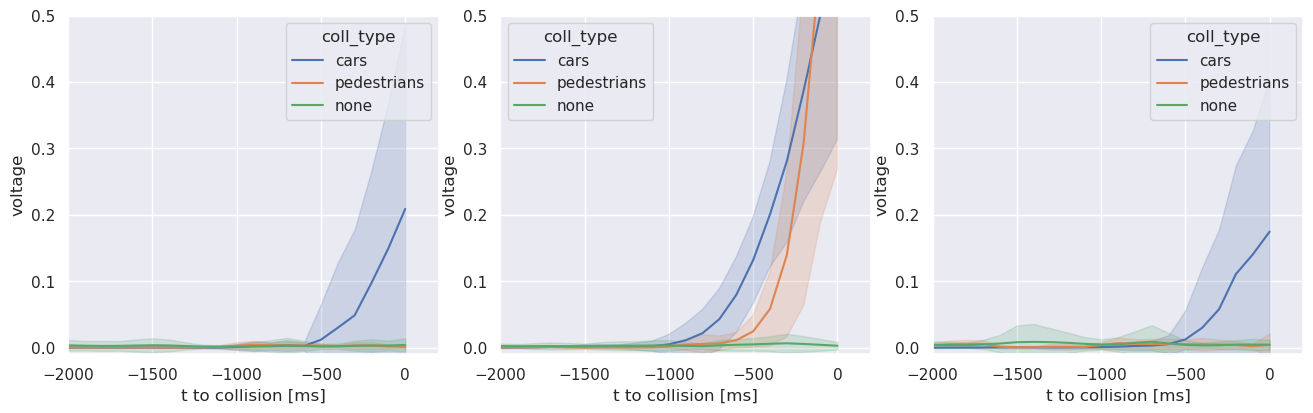

In [95]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "EMD")
]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]
    sns.lineplot(
        x="time",
        y="voltage",
        estimator="mean",
        data=_df_temp,
        sort=True,
        errorbar="sd",
        orient="x",
        hue="coll_type",
        ax=_ax
    )
    _ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

    _ax.set_ylim(top=0.5, bottom=-0.01)

fig.tight_layout(pad=0.2)

fig.savefig("responses_emd_3_tile_zoom.png", dpi=400)
fig.savefig("responses_emd_3_tile_zoom.pdf")

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

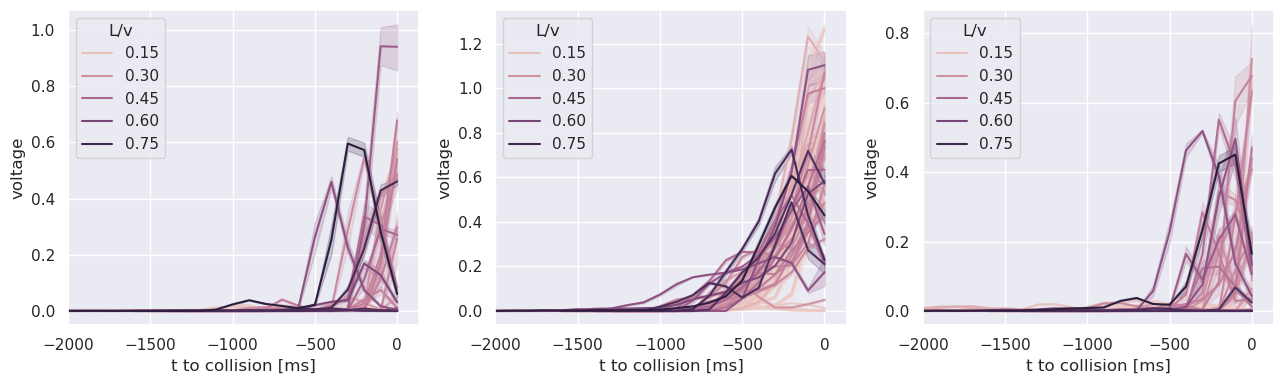

In [49]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "EMD") & (df_responses["coll_type"] != "none")
]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]
    sns.lineplot(
        x="time",
        y="voltage",
        estimator="mean",
        data=_df_temp,
        sort=True,
        orient="x",
        hue="L/v",
        ax=_ax
    )
    _ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

fig.tight_layout()

fig.savefig("l_v_responses_emd_3_tile.png", dpi=400)
fig.savefig("l_v_responses_emd_3_tile.pdf")

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

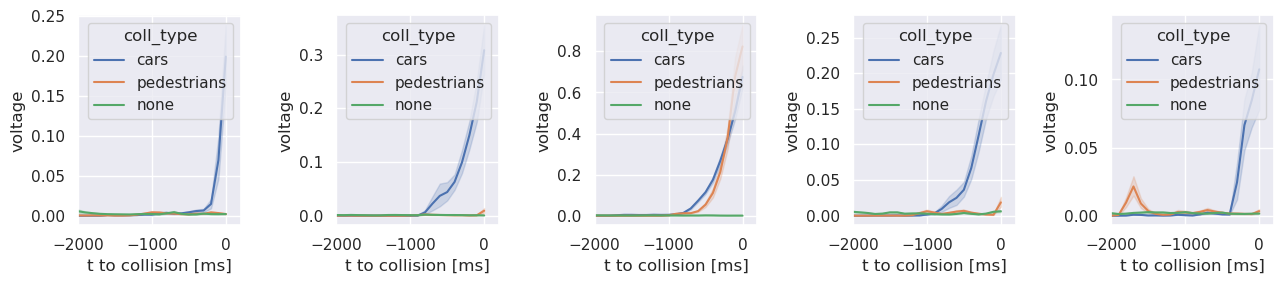

In [94]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 5) & (df_responses["model"] == "EMD")
]

fig, ax = plt.subplots(1, 5, figsize=(13, 3))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 2)
    ]
    sns.lineplot(
        x="time",
        y="voltage",
        estimator="mean",
        data=_df_temp,
        sort=True,
        orient="x",
        hue="coll_type",
        ax=_ax
    )
    _ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

fig.tight_layout()

fig.savefig("responses_emd_5_tile.png", dpi=400)

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

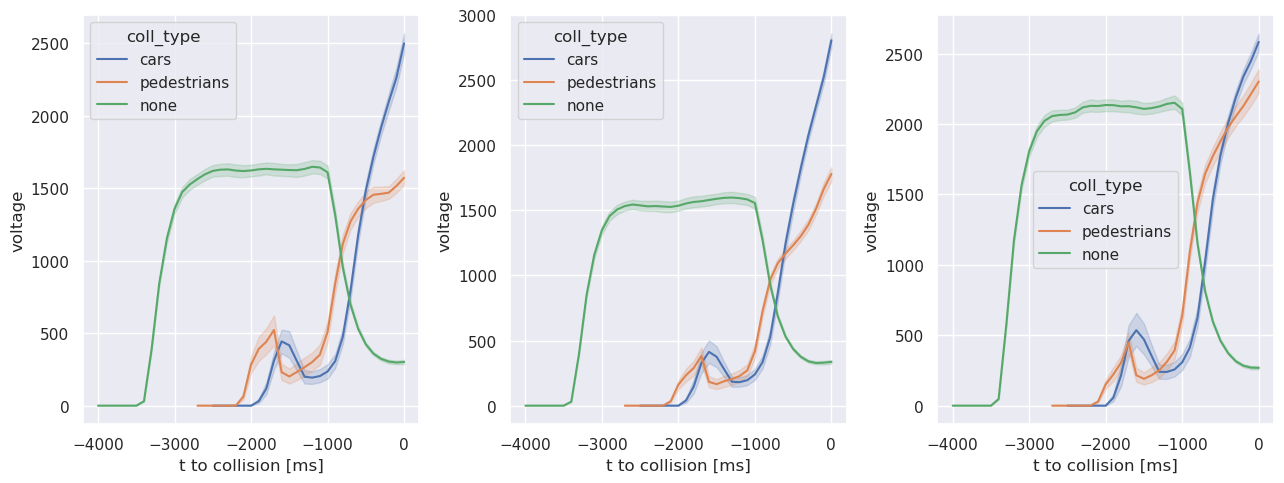

In [119]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "LGMD")
]

fig, ax = plt.subplots(1, 3, figsize=(13, 5))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]
    sns.lineplot(
        x="time",
        y="voltage",
        estimator="mean",
        data=_df_temp,
        sort=True,
        orient="x",
        hue="coll_type",
        ax=_ax
    )
    #_ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

fig.tight_layout()

fig.savefig("responses_lgmd_3_tile.png", dpi=400)

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

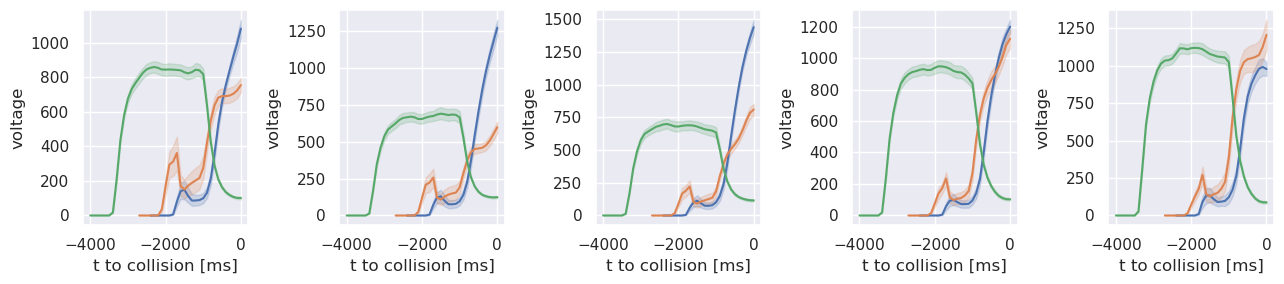

In [101]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 5) & (df_responses["model"] == "LGMD")
]

fig, ax = plt.subplots(1, 5, figsize=(13, 3))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 2)
    ]
    sns.lineplot(
        x="time",
        y="voltage",
        estimator="mean",
        data=_df_temp,
        sort=True,
        orient="x",
        hue="coll_type",
        ax=_ax,
        legend=False
    )
    #_ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

fig.tight_layout()

fig.savefig("responses_lgmd_5_tile.png", dpi=400)

plt.show()

In [104]:
df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    & (df_responses["tile_idx_x"] == 1)
]

,sample_id,model,n tiles,tile_idx_y,tile_idx_x,coll_type,coll_time,vel,diameter,voltage,time,L/v
1016508,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
1016509,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
1016510,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
1016511,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2300,0.576818
1016512,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2300,0.576818
...,...,...,...,...,...,...,...,...,...,...,...,...
1160361,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003490,0,NaN
1160362,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003186,0,NaN
1160363,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003138,0,NaN
1160364,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003515,0,NaN


In [130]:
df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    & (df_responses["tile_idx_x"] == 1)
].copy()

#df_emd["voltage"] += np.random.normal(0, 0.05, len(df_emd))

df_emd["positive"] = df_emd["coll_type"] != "none"
df_emd.loc[df_emd["coll_type"] == "none", "time"] += 2500.0

n_sweep = 20

min_react_time = np.linspace(0.0, 1500.0, n_sweep)
roc = []
roc_curve_sweep = []

for t in min_react_time:
    _df = df_emd[
        ((df_emd["time"] <= -t))
    ].copy()  # | (df_emd['positive'] == False)].copy()

    df_emd_max_resp = (
        _df.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc.append(roc_auc_score(df_emd_max_resp["positive"], df_emd_max_resp["voltage"]))
    roc_curve_sweep.append(
        roc_curve(df_emd_max_resp["positive"], df_emd_max_resp["voltage"])
    )

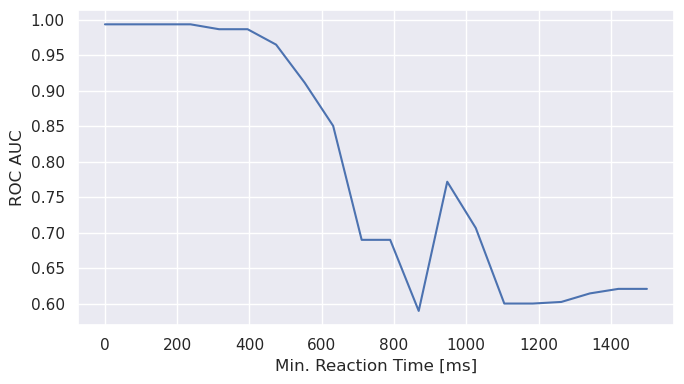

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.plot(min_react_time, roc)
ax.set_ylabel("ROC AUC")
ax.set_xlabel("Min. Reaction Time [ms]")

fig.tight_layout()
fig.savefig("roc_emd.png", dpi=400)
plt.show()

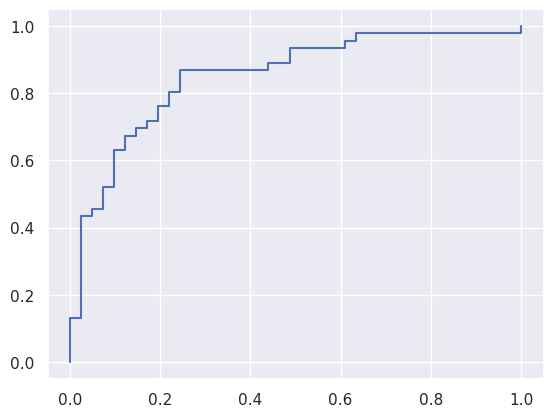

In [135]:
plt.plot(roc_curve_sweep[-12][0], roc_curve_sweep[-12][1])
plt.show()

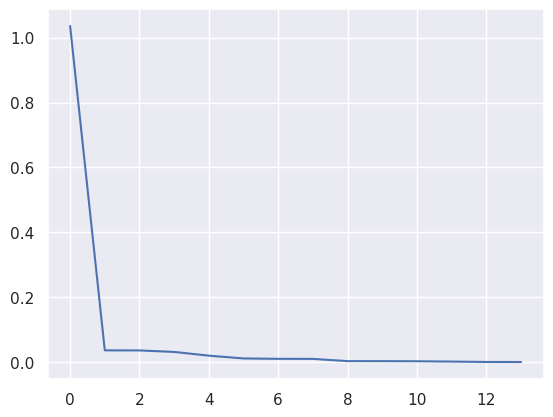

In [113]:
plt.plot(roc_curve_sweep[15][2])
plt.show()